In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from pprint import pprint
import pandas as pd
import gzip

In [62]:
%load_ext autoreload
%autoreload 1
%aimport models
%aimport main
%aimport data_utils
%aimport contrastive_data
%aimport scoring

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
from contrastive_data import *
from data_utils import *
from main import *
from models import *
from scoring import *
from glob import glob

# Data and model

In [4]:
data_path = '/home/lguirardel/data/nabid_data/p53pilot/Data/RawData/filtered_feature_bc_matrix/wrangled'

In [5]:
group_wt_like = False
paths = get_paths(data_path, subset = 'filtered')
counts = load_data(*paths, group_wt_like=group_wt_like)

	Reading files...
		Reading matrix


		Reading genes and cells
			Permuting gene columns to match gene file
		Reading variant data
	Merging and processing...
		10 variant classes


## Run from here to re-split without reloading all data

(will be necessary if wtlike is changed however)

In [6]:
#CELL TO CHANGE
run_name = 'nabid_sc_1_1'
run_dir = 'nabid_sc_1/nabid_sc_1_1'
# BAG_SIZE = 50
dir_name = join('models',run_dir)
dataset_class = BatchDataset
! cat models/{run_dir}/config.ini

dest-name = nabid_sc_1
verbose = 1
load-split = nabid_sc_1/nabid_sc_1_0
data-subset = filtered
unseen-fraction = 0.0
loss = standard
dropout = 0.002049884663535571
weight-decay = 8.26539945887345e-05
batch-size = 512
shape = [1001, 1001, 1001]
embed-dim = 20
n-epochs = 200
lr = 0.00018355721421662116
scheduler = restarts
cosine-t = 404
task = classifier
margin = 1
alpha = 0
positive-fraction = 0.5
patience = 40
knn = 5
bag-size = 0
mil-mode = attention
n-workers = 0


## FOR `sc_1` :ONLY

The R165H were unintentionally dropped, so we'll need to drop them again here

In [7]:
if run_name.startswith('nabid_sc_0'):
    counts = counts[~ counts.variant.str.startswith('R175H')]
    counts.variant = counts.variant.cat.remove_unused_categories()

In [8]:
df_train, df_seen, df_unseen = load_split(join(dir_name, 'split'), counts, )
df_dict = {
    'train':df_train,
    'seen':df_seen,
    'unseen':df_unseen,
}

3172, 1057, 0 exemples in data
10 variants in train
0 variants in unseen


In [9]:
dl_train, dl_seen, dl_unseen = make_loaders(
    df_train, df_seen,df_unseen, batch_size=64, dataset_class=dataset_class,n_workers=1,pos_frac=0.5, 
    # dataset_kwargs={'bag_size':BAG_SIZE}
    )
dl_dict = {
    'train':dl_train,
    'seen':dl_seen,
    'unseen':dl_unseen,
}

In [10]:
model :Model = torch.load(join(dir_name,'best_model.pkl'), map_location='cpu')
model.eval()

Classifier(
  (network): MLP(
    (layers): Sequential(
      (0): Linear(in_features=27359, out_features=1001, bias=True)
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.002049884663535571, inplace=False)
      (3): Linear(in_features=1001, out_features=1001, bias=True)
      (4): ELU(alpha=1.0)
      (5): Dropout(p=0.002049884663535571, inplace=False)
      (6): Linear(in_features=1001, out_features=1001, bias=True)
      (7): ELU(alpha=1.0)
      (8): Dropout(p=0.002049884663535571, inplace=False)
      (9): Linear(in_features=1001, out_features=20, bias=True)
    )
  )
  (output_layer): Linear(in_features=20, out_features=10, bias=True)
)

In [11]:
!cat models/{run_dir}/best_score.json

{
  "5_nn_ref_seen": 0.8013245033112583,
  "i": 82
}

In [12]:
fclass = df_seen[['variant','Variant functional class']].value_counts()\
    .reset_index('Variant functional class').drop(columns='count').squeeze()
fclass

variant
eGFP                  Control
P53.BC2               WT-like
R175H.P53.BC5    Impactful II
EV.BC9                Control
P53.BC1               WT-like
R175H.P53.BC7    Impactful II
P53.BC3               WT-like
R175H.P53.BC6    Impactful II
P53.BC4               WT-like
R175H.P53.BC8    Impactful II
Name: Variant functional class, dtype: object

In [13]:
conditions = pd.read_csv('~/data/nabid_data/p53pilot/Data/conditions.csv', index_col=0)
conditions = conditions.rename(columns = {f'P53.BC{i}':f'R175H.P53.BC{i}' for i in range(5,9)})

## Compute embeddings

In [14]:
emb_dict = {}
for k, df in df_dict.items():
    with torch.no_grad():
        X = torch.tensor(df.drop(columns=['variant','Variant functional class','cycle' ]).to_numpy(), dtype=torch.float32)[:, None, None, :] #(B, 1, 1, d)
        embeds = model.network.embed(X).squeeze()

    # emb_dict[k] = (embeds - embeds.mean(dim=0, keepdim=True)) / embeds.norm(dim=0, keepdim=True) # no : we want plots to represent distances in embed space 
    emb_dict[k] = embeds    

In [15]:
emb_dict['train'].shape

torch.Size([3172, 20])

# Embed PCA

In [16]:
pca = PCA(2).fit(emb_dict['seen'])

# Embedding distribution

In [17]:
make_dir_if_needed(f'plots/embeds/{run_name}')

In [18]:
hue_order = ['Control','WT-like', 'Impactful II',]


In [19]:
subset = 'seen'
df = df_dict[subset]
embeds = emb_dict[subset]
emb_red = pca.transform(embeds)


In [20]:
print(f'Explained variance : {(pca.explained_variance_ratio_).sum()*100:.1f} %')


Explained variance : 48.7 %


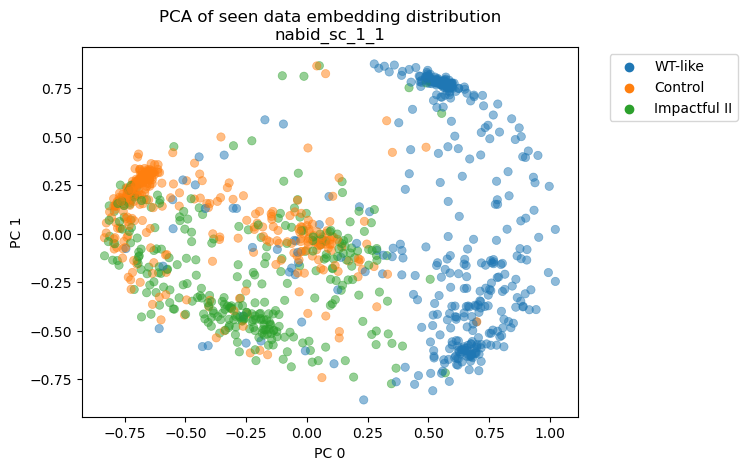

In [21]:
## SCATTER PLOT - WT-SYN VS OTHERS
hue = df['variant'].map(fclass)
ax = sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], hue =hue, 
                alpha=0.1 if subset=='train' else 0.5, legend=True,
                edgecolor=None
                )
# sns.kdeplot(x=emb_red[:,0], y=emb_red[:,1], hue =hue, 
#             levels=5, common_norm=False, )
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {subset} data embedding distribution\n{run_name}' )
# put legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(f'plots/embeds/{run_name}/{subset}_embed_pca_fclass.pdf')

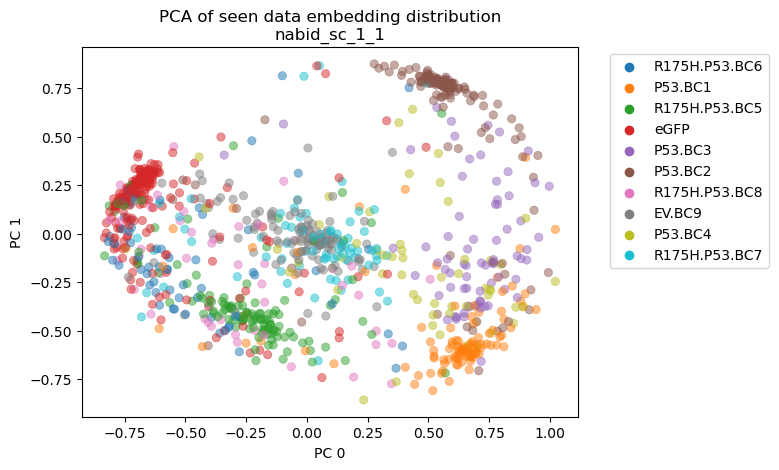

In [22]:
hue = df['variant']
ax = sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], hue =hue, 
                alpha=0.1 if subset=='train' else 0.5, legend=True,
                edgecolor=None
                )
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {subset} data embedding distribution\n{run_name}' )
# put legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(f'plots/embeds/{run_name}/{subset}_embed_pca_variant.pdf')

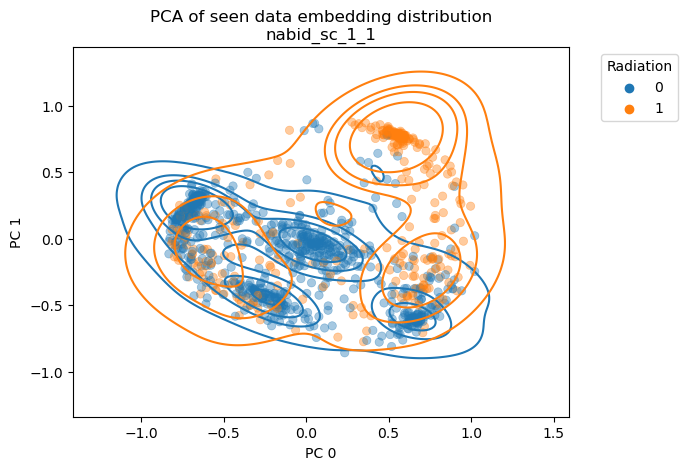

In [23]:
hue = conditions.loc['Radiation'][df['variant']]
ax = sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], hue =hue, 
                alpha=0.1 if subset=='train' else 0.4, legend=True,
                edgecolor=None
                )
sns.kdeplot(x=emb_red[:,0], y=emb_red[:,1],  hue =hue, 
            levels=5, common_norm=False, legend = False)

plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {subset} data embedding distribution\n{run_name}' )
# put legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=hue.name)
plt.savefig(f'plots/embeds/{run_name}/{subset}_embed_pca_radiation.pdf')

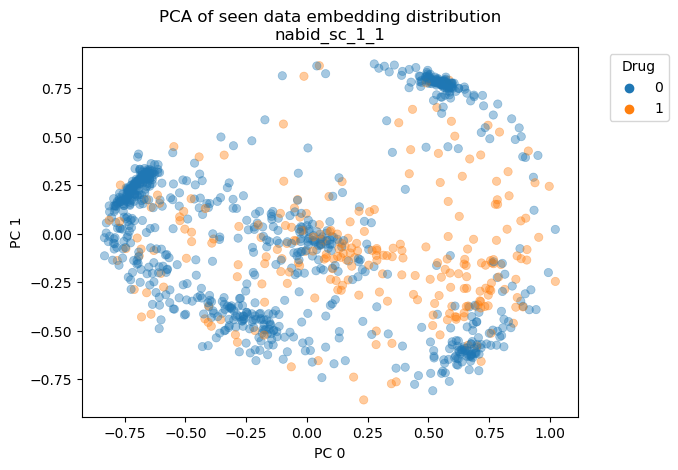

In [24]:
hue = conditions.loc['Drug'][df['variant']]
ax = sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], hue =hue, 
                alpha=0.1 if subset=='train' else 0.4, legend=True,
                edgecolor=None
                )
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {subset} data embedding distribution\n{run_name}' )
# put legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=hue.name)
plt.savefig(f'plots/embeds/{run_name}/{subset}_embed_pca_drug.pdf')

# kNN scores

This section compares the embedding with :
- PCA (20 dim, 150 dim)
- 150 best DeepLIFT genes (as identified in my internship thesis)
- Full transcriptome

In [25]:
make_dir_if_needed(f'plots/scores/{run_name}')

## ref knn

### Score

This score needs a reference (training) and a test set (seen). We do not use unseen variants as this is the ref-knn score.

In [67]:
k=5
knn = KNeighborsClassifier(k)
## EMBEDDINGS
y_test, y_pred, (y_train, X_train, X_test, emb_train, emb_test) =\
      knn_ref_predict(model.network, dl_train, dl_seen, k, device='cuda', return_x=True)

## PCA
pca_20 = PCA(20)
train_pca_20 = pca_20.fit_transform(X_train)
test_pca_20 = pca_20.transform(X_test)
pca_150 = PCA(150)
train_pca_150 = pca_150.fit_transform(X_train)
test_pca_150 = pca_150.transform(X_test)

red_dict = {
    'embeds':[emb_train, emb_test],
    'pca_20':[train_pca_20, test_pca_20],
    'pca_150':[train_pca_150, test_pca_150],
}
score_dict = {}
for k, (train, test) in red_dict.items():
    knn.fit(train, y_train)
    y_pred = knn.predict(test)
    s = accuracy_score(y_test, y_pred)
    score_dict[k] = s
    print(f'{k}\t{s:.3f}')


embeds : 0.801
pca_20 : 0.448
pca_150 : 0.493


In [65]:
n_cell = len(dl_train.dataset.y)
# count values in tensor
n_max = torch.bincount(dl_train.dataset.y).max()

In [69]:
print(dir_name)
print(f'''Ref-seen score {score_dict['embeds']*100:.2f} % ({k}-nn). 
Best constant predictor : {100*n_max/n_cell:.2f} %. 
PCA-20 score : {score_dict['pca_20']*100:.2f} %''')

models/nabid_sc_1/nabid_sc_1_1
Ref-seen score 80.13 % (pca_150-nn). 
Best constant predictor : 21.28 %. 
PCA-20 score : 44.84 %


In [29]:
# print(pd.Series(torch.bincount(dl_train.dataset.y), index = dl_train.dataset.cats[:75]).sort_values(ascending=False))

### Confusion matrix

In [30]:
dl_train.dataset.cats[:75]

Index(['R175H.P53.BC6', 'P53.BC1', 'R175H.P53.BC5', 'eGFP', 'P53.BC3',
       'P53.BC2', 'R175H.P53.BC8', 'EV.BC9', 'P53.BC4', 'R175H.P53.BC7'],
      dtype='object')

In [31]:
sl =slice(None,np.unique(y_test).max()+1) 
# fclass = variant_data['Variant functional class'][dl_train.dataset.cats[sl ]] # defined in intro

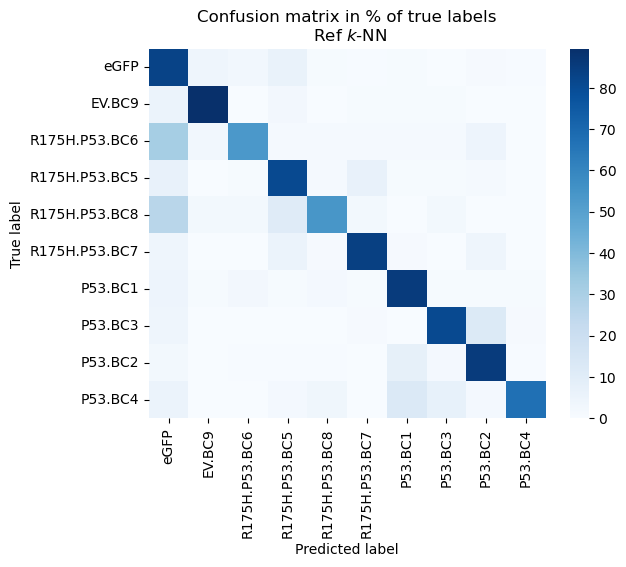

In [32]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, y_pred)
confusion = pd.DataFrame(confusion, index=dl_train.dataset.cats[sl], columns=dl_train.dataset.cats[sl])  
confusion.index.name = 'True label'
confusion.columns.name = 'Predicted label'

confusion = pd.concat([group for _, group in confusion.groupby(fclass)])
confusion = pd.concat([group for _, group in confusion.T.groupby(fclass)]).T
confusion = confusion.div(confusion.sum(axis=1), axis=0)*100

# seaborn plot
sns.heatmap(confusion, annot=False, fmt='d', cmap='Blues',)
plt.title('Confusion matrix in % of true labels\n Ref $k$-NN')
plt.savefig(f'plots/scores/{run_name}/{run_name}_confusion_ref_knn.pdf')


(array([85.,  3.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  7.]),
 array([ 0.        ,  8.94736842, 17.89473684, 26.84210526, 35.78947368,
        44.73684211, 53.68421053, 62.63157895, 71.57894737, 80.52631579,
        89.47368421]),
 <BarContainer object of 10 artists>)

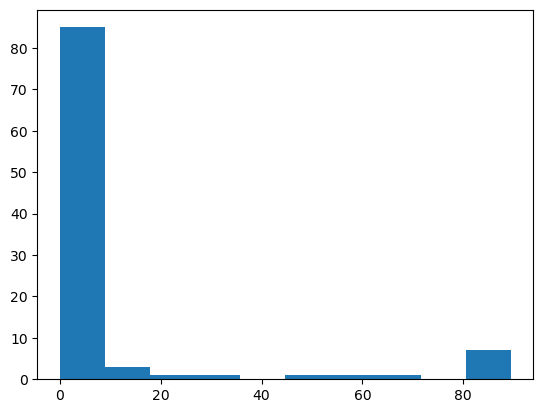

In [33]:
plt.hist(confusion.to_numpy().flatten())

In [34]:
pd.Series(np.diag(confusion), index = confusion.index).sort_values(ascending=False) 

True label
EV.BC9           89.473684
P53.BC2          85.454545
P53.BC1          85.321101
R175H.P53.BC7    84.210526
eGFP             82.905983
P53.BC3          81.081081
R175H.P53.BC5    80.833333
P53.BC4          67.272727
R175H.P53.BC8    54.347826
R175H.P53.BC6    53.125000
dtype: float64

Predicted variant   Control  Impactful II   WT-like
True variant                                       
Control            0.907445      0.070963  0.021592
Impactful II       0.183125      0.770418  0.046457
WT-like            0.043594      0.037615  0.918791


Text(0.5, 1.0, 'Confusion matrix in % of true labels\nRef $k$-NN')

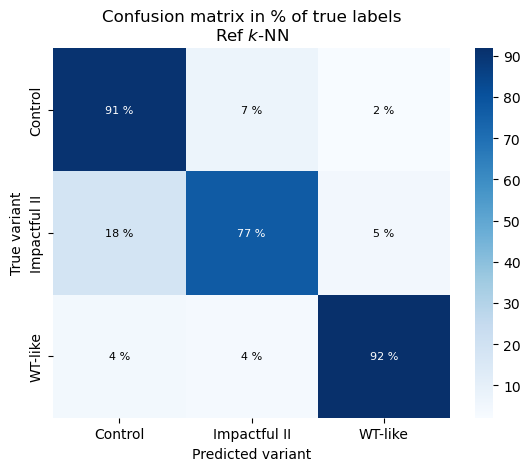

In [35]:
confusion_fc = confusion.groupby(fclass).sum().T.groupby(fclass).sum().T
confusion_fc = confusion_fc.div(confusion_fc.sum(axis=1), axis=0)
confusion_fc.index.name = 'True variant'
confusion_fc.columns.name = 'Predicted variant'
sns.heatmap(confusion_fc*100, cmap='Blues', annot=False) #annot is bugged in seaborn 0.12.2
# manual annotate
for i in range(confusion_fc.shape[0]):
    for j in range(confusion_fc.shape[1]):
        plt.text(j+0.5, i+0.5, f'{confusion_fc.iloc[i,j]*100:.0f} %', ha='center', va='center', fontsize=8, 
                 color='white' if confusion_fc.iloc[i,j] > 0.5 else 'black')
print(confusion_fc)
plt.title('Confusion matrix in % of true labels\nRef $k$-NN')

## self knn

### Score

In [36]:
subset = 'seen'
dl = dl_seen

model_ = model.network
device = 'cuda'
model_.eval()
model_ = model_.to(device)
embed, y_true, x_cell = [], [], []
for x,y in dl: # x,y are tuples of tensors of any size, we're taking the first one
    with torch.no_grad():
        embed.append(model_.embed(x[0].to(device)).cpu().squeeze())
        y_true.append(y[0])
        x0 = x[0].squeeze()
        if len(x[0].shape) > 2:
            x_cell.append(x0.mean(1))
        else:
            x_cell.append(x0)
embed = torch.concat(embed)
y_true = torch.concat(y_true)
x_red = PCA(20).fit_transform(torch.concat(x_cell))


In [37]:
knn = KNeighborsTransformer(n_neighbors=k)
y_true = y_true.cpu().numpy()
knn.fit(embed.cpu(), )
graph = knn.kneighbors_graph()
y_pred = y_true[find(graph)[1]] # neighbors' y (find(graph)[1] are the target nodes in the knn graph)
y_pred = y_pred.reshape((-1, k)) # (kN, ) -> (N, k)
y_pred = mode(y_pred.T).mode
s= accuracy_score(y_true, y_pred)

In [38]:
knn.fit(x_red, )
graph = knn.kneighbors_graph()
y_pred_pca = y_true[find(graph)[1]] # neighbors' y (find(graph)[1] are the target nodes in the knn graph)
y_pred_pca = y_pred_pca.reshape((-1, k)) # (kN, ) -> (N, k)
y_pred_pca = mode(y_pred_pca.T).mode
s_pca = accuracy_score(y_true, y_pred_pca)

In [39]:
n_max = np.unique(y_true, return_counts=True)[1].max()
n_cell = len(y_true)
print(f'Score {s*100:.2f} % ({k}-nn). Best constant predictor : {100*n_max/n_cell:.2f} %. Score PCA : {s_pca*100:.2f} %')

Score 80.51 % (5-nn). Best constant predictor : 22.14 %. Score PCA : 36.90 %


### Confusion matrix

Text(0.5, 1.0, 'Confusion matrix in % of true labels\nself seen')

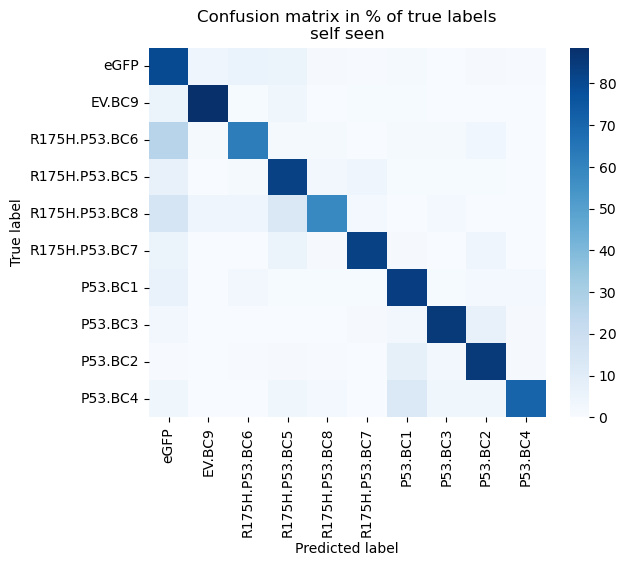

In [40]:

confusion = confusion_matrix(y_true, y_pred)
confusion = pd.DataFrame(confusion, index=dl_train.dataset.cats[sl], columns=dl_train.dataset.cats[sl])  
confusion.index.name = 'True label'
confusion.columns.name = 'Predicted label'

confusion = pd.concat([group for _, group in confusion.groupby(fclass)])
confusion = pd.concat([group for _, group in confusion.T.groupby(fclass)]).T
confusion = confusion.div(confusion.sum(axis=1), axis=0)*100

# seaborn plot
sns.heatmap(confusion, annot=False, fmt='d', cmap='Blues',)
plt.title(f'Confusion matrix in % of true labels\nself {subset}')

In [41]:
pd.Series(np.diag(confusion), index = confusion.index).sort_values(ascending=False) 

True label
EV.BC9           88.596491
P53.BC2          85.454545
P53.BC3          85.135135
P53.BC1          83.486239
R175H.P53.BC7    82.894737
R175H.P53.BC5    82.500000
eGFP             79.914530
P53.BC4          70.909091
R175H.P53.BC6    62.500000
R175H.P53.BC8    58.695652
dtype: float64

# Clustering

In [42]:
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score
make_dir_if_needed(f'plots/clustering/{run_name}')

## KMEANS clustering of embeddings

### Evaluate number of clusters

In [43]:
emb_dict['seen'].shape

torch.Size([1057, 20])

In [44]:
s = []
c = []
for i in tqdm(range(2,20)):
    kmeans = KMeans(n_clusters=i)
    labels = kmeans.fit_predict(emb_dict['seen'])
    s.append(silhouette_score(emb_dict['seen'], labels))
    c.append(kmeans.inertia_)


 22%|██▏       | 4/18 [00:00<00:00, 31.72it/s]

100%|██████████| 18/18 [00:00<00:00, 23.75it/s]


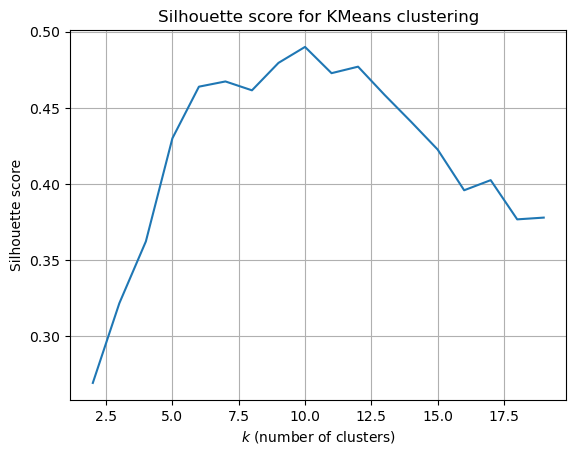

In [45]:
plt.plot(range(2,len(s)+2),s)
plt.title('Silhouette score for KMeans clustering')
plt.xlabel('$k$ (number of clusters)')
plt.ylabel('Silhouette score')
plt.grid()
plt.savefig(f'plots/clustering/{run_name}/silhouette_score.pdf')

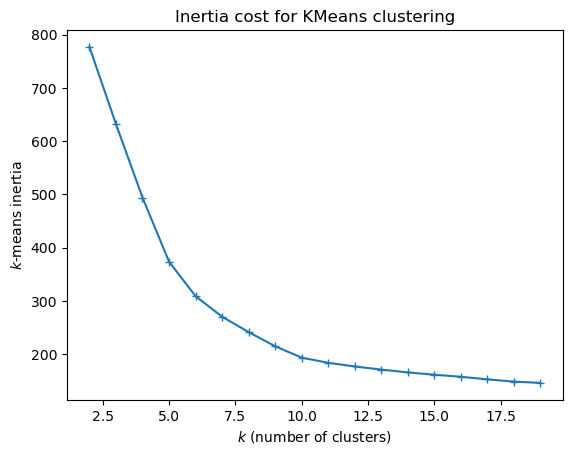

In [46]:
plt.plot(range(2,len(c)+2),c, '+-')
plt.title('Inertia cost for KMeans clustering')
plt.xlabel('$k$ (number of clusters)')
plt.ylabel('$k$-means inertia')
plt.savefig(f'plots/clustering/{run_name}/{run_name}_inertia.pdf')

10 clusters, 10 conditions

### Plot cluster

In [47]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=4)
labels = kmeans.fit_predict(emb_dict['seen'])
emb_red = pca.transform(emb_dict['seen'])

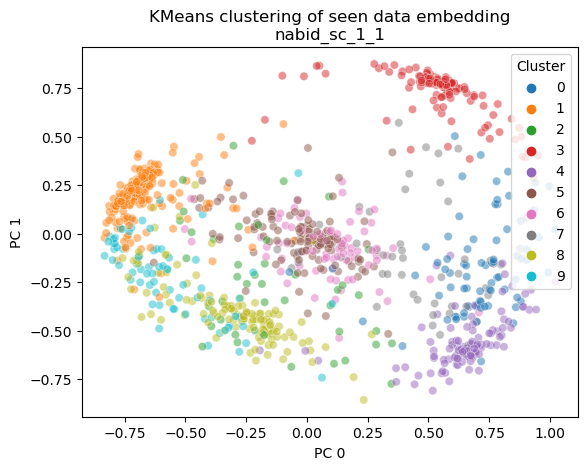

In [48]:
# scatter plot
sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], hue = labels, palette='tab10', alpha=0.5, legend=True)
plt.legend(title='Cluster')
plt.title(f'KMeans clustering of seen data embedding\n{run_name}')
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
# legend outside plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(f'plots/clustering/{run_name}/{run_name}_kmeans_scatter.pdf')

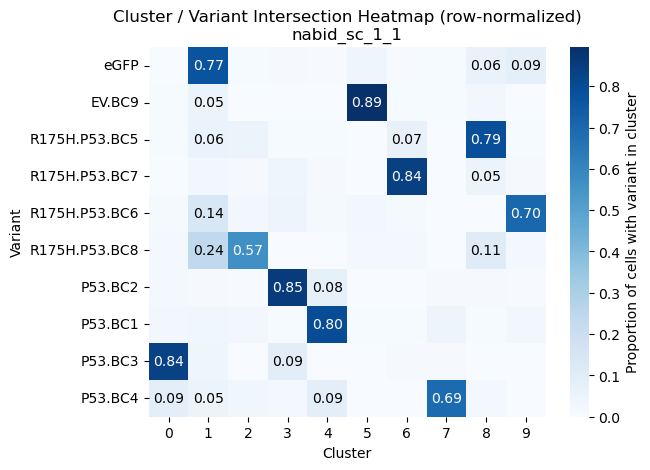

In [49]:
# main_var_only = False # set to False to include all variants
# Create a dataframe with cluster labels and variant names
df_heatmap = pd.DataFrame({'Cluster': labels, 'Variant': df_seen['variant']})

# Pivot the dataframe to create a matrix of cluster-variant intersection
heatmap_data = df_heatmap.pivot_table(index='Cluster', columns='Variant', aggfunc=len, fill_value=0).T
heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0) # normalize by row
heatmap_data = heatmap_data.reindex(fclass.index)

heatmap_data = pd.concat([group for _, group in heatmap_data.groupby(fclass)])

# Create the heatmap
heatmap = sns.heatmap(heatmap_data, cmap='Blues', vmin=0,
                      )
heatmap.set_title('Cluster / Variant Intersection Heatmap (row-normalized)\n'+run_name)
heatmap.set_xlabel('Cluster')
heatmap.set_ylabel('Variant')
cbar = heatmap.collections[0].colorbar
cbar.set_label('Proportion of cells with variant in cluster')

# Add annotations to the heatmap

for i in range(heatmap_data.shape[0]):
    for j in range(heatmap_data.shape[1]):
        value = heatmap_data.iloc[i, j]
        if value > 0.05:
            heatmap.annotate(f'{value:.2f}', (j + 0.5, i + 0.5), ha='center', va='center',
                            color = 'black' if value < cbar.vmax/2 else 'white'
                            )
plt.savefig(f'plots/clustering/{run_name}/{run_name}_cluster_variant_heatmap_row.pdf')


# Embedding PCA variance plot

In [54]:
df_seen.drop(columns=['cycle','Variant functional class', 'variant']).std()

ENSG00000000003    1.437466
ENSG00000000005    0.000000
ENSG00000000419    1.607017
ENSG00000000457    0.382765
ENSG00000000460    0.645064
                     ...   
ENSG00000288235    0.000000
ENSG00000288253    0.122156
ENSG00000288380    0.208707
ENSG00000288398    0.186947
ENSG00000288460    0.030758
Length: 27359, dtype: float64

X_norm shape (3172, 25511)


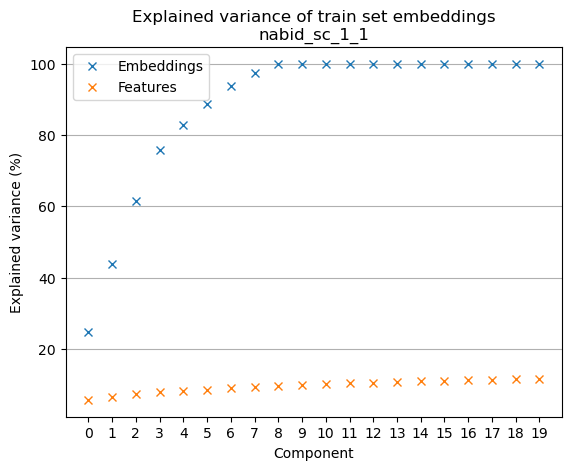

In [59]:
subset='train'
embeds = emb_dict[subset]

n = embeds.size(1)
embeds_norm = (embeds - embeds.mean(-1, keepdim=True))/embeds.std(-1, keepdim=True)
X_norm = df_dict[subset].drop(columns=['variant','Variant functional class','cycle' ])
X_norm = ((X_norm - X_norm.mean())/X_norm.std()).dropna(axis=1) # drop columns with 0 variance
print('X_norm shape', X_norm.shape)
pca_2 = PCA(n).fit(embeds_norm)
pca_X = PCA(n).fit(X_norm)
plt.plot(range(n), 100* np.cumsum(pca_2.explained_variance_ratio_), 'x', label='Embeddings')
plt.plot(range(n), 100* np.cumsum(pca_X.explained_variance_ratio_), 'x', label='Features')
plt.legend()
plt.ylabel('Explained variance (%)')
plt.xlabel('Component')
plt.title(f'Explained variance of {subset} set embeddings\n{run_name}')
plt.grid(axis='y')
plt.xticks(range(n))
plt.savefig(f'plots/embeds/{run_name}/embed_pca_variance.pdf');

# Comparison with simple PCA

In [51]:
def normalize(df):
    return (df - df.mean())/df.std()

In [52]:
subset = 'seen'
pca_base = PCA(2).fit(normalize(df_train.iloc[:,:-3]))

df = df_dict[subset]
X_red = pca_base.transform(normalize(df.iloc[:,:-3]))


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
print(f'Explained variance : {(pca_base.explained_variance_ratio_).sum()*100:.1f} %')


Explained variance : 5.1 %


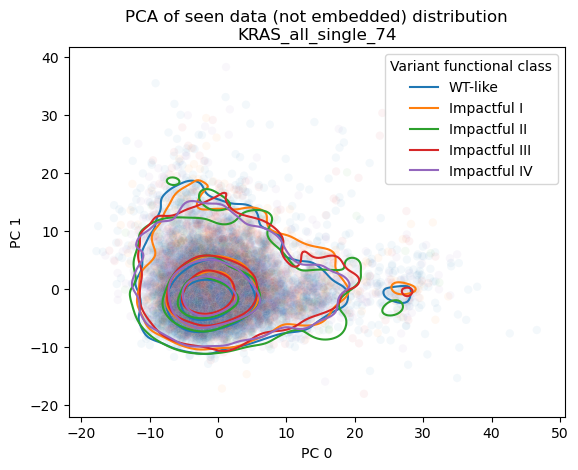

In [ ]:
sns.scatterplot(x=X_red[:,0], y=X_red[:,1], hue = df['Variant functional class'], hue_order=hue_order, alpha=0.05, legend=False)
sns.kdeplot(x=X_red[:,0], y=X_red[:,1], hue = df['Variant functional class'], hue_order=hue_order, levels=4, common_norm=False)
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {subset} data (not embedded) distribution\n{run_name}' )
plt.savefig(f'plots/embeds/{run_name}/{subset}_pca_kde.pdf')

Text(0.5, 1.0, 'PCA of WT, R273C embedding distribution\ncls_tp53_0_best, seen')

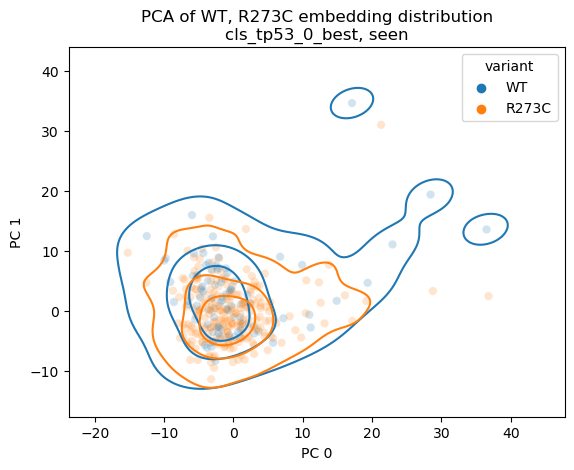

In [ ]:
variants = ['WT', 'R273C']
# variant = 'C277F'
# df2 = df[f]
# variant_list = df2.variant.unique()

hue = df.variant.map(lambda x : x if x in variants else 'Other')

f = hue != 'Other'

sns.kdeplot(x=X_red[f,0], y=X_red[f,1], hue =hue[f], legend=False, common_norm=False, levels = 4,
            hue_order=variants
            )

# hue = df['cycle'][f]
sns.scatterplot(x=X_red[f,0], y=X_red[f,1], hue =hue[f],  alpha=0.2, legend=True,
            hue_order=variants
            )



plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {", ".join(variants)} embedding distribution\n{run_name}, {subset}' )
# plt.savefig(f'plots/embeds/{run_name}/{subset}_variants_refpca_kde.pdf')

In [ ]:
df.iloc[:,:-3].std(axis=0).sort_values()

NTS              0.726865
RP11-338I21.1    0.735849
LINC01220        0.846769
SCG2             0.873338
VCAN             0.889288
                   ...   
CCL26            1.021527
FBXO32           1.021564
RTN2             1.025186
AC006262.5       1.035991
GACAT2           1.043334
Length: 1145, dtype: float64